# Reproduce Published Results
This example shows how to use alternative software with the published data to reproduce published XAS results.

The input files to be used are the same as those of the Demeter (perl) example.

This example replicates one by one the same operations implementer in the Demeter example

# Libraries 
The following cell includes the libraries imported for  reproduction of results.

In [1]:
# Larch Libraries
# library to read ascii files
from larch.io import read_ascii, read_athena
# libraries to handle data groups
from larch.utils import group2dict, dict2group
# library to normalise data
from larch.xafs import pre_edge

# perform background removal
from larch.xafs import autobk
# calculate fourier transform
from larch.xafs import xftf

# import the larch.io libraries for managing athena files
from larch.io import create_athena, read_athena, extract_athenagroup

# File handling
from pathlib import Path

#plotting library
%matplotlib inline
import matplotlib.pyplot as plt

#library for writing to log
import logging

# custom libraries
# read/write csv data
import lib.handle_csv as hcsv

# Functions
The following cell includes the custom functions defined for enabling reproduction of results.

In [6]:
# initialise log file
def set_logger(log_file):
    logger = logging.getLogger()
    fhandler = logging.FileHandler(filename=log_file, mode='a')
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    fhandler.setFormatter(formatter)
    logger.addHandler(fhandler)
    # prevent matplotlib font manager from writing to log
    logging.getLogger('matplotlib.font_manager').disabled = True
    logger.setLevel(logging.DEBUG)

#reading all with the same extension files from a dir
def get_files_list(source_dir, f_pattern):
    i_counter = 0
    files_list = []
    for filepath in sorted(source_dir.glob(f_pattern)):
        i_counter += 1
        files_list.append(filepath)
    return files_list

# Rename columns 
def rename_cols(xafs_group):
    # energy
    engy = xafs_group.col1
    # mu
    mu_e = xafs_group.col2
    # get a dictionary from te group
    xafs_dict = group2dict(xafs_group)
    # add mu and energy to the dictionary
    xafs_dict['energy'] = engy
    xafs_dict['mu'] = mu_e
    xafs_group = dict2group(xafs_dict)
    return xafs_group

# show plot of normalised data
def plot_normalised(xafs_group):
        plt.plot(xafs_group.energy, xafs_group.pre_edge, 'g', label='pre-edge') # plot pre-edge in green
        plt.plot(xafs_group.energy, xafs_group.post_edge, 'r', label='post-edge')# plot post-edge in red
        plt.plot(xafs_group.energy, xafs_group.mu, 'b', label=xafs_group.filename) # plot mu in blue
        plt.grid(color='r', linestyle=':', linewidth=1) #show and format grid
        plt.xlabel('Energy (eV)') # label y graph
        plt.ylabel('x$\mu$(E)') # label y axis
        plt.title("pre-edge and post_edge fitting to $\mu$")
        plt.legend() # show legend

def plot_norm_mu_energy(all_groups, plot_groups, plotparams, xminmax):
    print(xminmax)
    
    for a_group in plot_groups:
        print(a_group, type(a_group))
        
    first_group = int(plot_groups[0])
    #xmin=0, xmax=1
    e_zero = all_groups[first_group].e0
    xmin=e_zero + float(xminmax [2])
    xmax=e_zero + float(xminmax [3])
    plt.xlim(xmin,xmax)
    plt.legend()
    for idx in plot_groups:
        plt.plot(all_groups[int(idx)].energy, all_groups[int(idx)].norm,
                 label = all_groups[int(idx)].label) 
    plt.show()
        

# Extract groups from Athena project and return it with 
# the specified name 

def get_athena_data(data_file, group_label, group_name):
    athena_group = None
    athena_project = read_athena(data_file)
    group_keys=list(athena_project._athena_groups.keys())
    for group_key in group_keys:
        gr_0 = extract_athenagroup(athena_project._athena_groups[group_key])
        if gr_0.label == group_label:
            athena_group = gr_0
            athena_group.label = group_name
            break
    athena_group = calc_with_defaults(athena_group)
    return athena_group
        
        
# use the list of athena groups to retrieve data from the athena projects
def get_data(data_sources):
    project_groups = []
    for a_ds in data_sources:
        data_file = a_ds[0]
        read_as = a_ds[1]
        group_name = a_ds[2]
        if data_file[-4:] == ".prj":
            print ("reading from athena file: ", data_file , "\n")
            project_groups.append(get_athena_data(data_file, read_as, group_name))
        else:
            print ("reading from column file: ", data_file , "\n")
            project_groups.append(get_column_data(data_file, read_as, group_name))
    return project_groups;

def calc_with_defaults(xafs_group):
    # calculate mu and normalise with background extraction
    # should let the user specify the colums for i0, it, mu, iR. 
    if not hasattr(xafs_group, 'mu'):
        xafs_group = get_mu(xafs_group)
    # calculate pre-edge and post edge and add them to group
    # need to read parameters for pre-edge before background calculation with  
    # defaul values undo the work of previous step (setting pre-edge limits).
    pre_edge(xafs_group, pre1=xafs_group.athena_params.bkg.pre1, pre2=xafs_group.athena_params.bkg.pre2)
    #pre_edge(xafs_group)
    # perform background removal
    autobk(xafs_group) # using defaults so no additional parameters are passed
    # calculate fourier transform
    xftf(xafs_group)#, kweight=0.5, kmin=3.0, kmax=12.871, dk=1, kwindow='Hanning')
    return xafs_group


# Input parameters (variables)

The variables in the next cell are the processing values that indicate where to get the data from, the pattern of the files to process and the number of files to process. These can be changed to process different datasets.


In [7]:
base_prefix = "pub_037"
athena_groups_file = "../inputdata/pub_037_athena.csv"
operations_list_file = "../inputdata/pub_037_operations.csv"

[root] INFO : Started processing
[root] INFO : Input variables:
[root] INFO : prefix = pub_037
[root] INFO : reading from athena file = ../inputdata/pub_037_athena.csv
[root] INFO : reading from operations file = ../inputdata/pub_037_operations.csv
[root] INFO : recovering data groups


pub_037\process.log
reading from athena file:  ..\Larch\wf_data\pub_037\XAFS_prj\SnO2 0.9 2.6-13.5 gbkg.prj 

reading from athena file:  ..\Larch\wf_data\pub_037\XAFS_prj\Sn K-edge\PtSn_OCO.prj 

reading from athena file:  ..\Larch\wf_data\pub_037\XAFS_prj\Sn K-edge\PtSn_OCA.prj 

reading from athena file:  ..\Larch\wf_data\pub_037\XAFS_prj\Sn K-edge\PtSn_OCH.prj 

reading from athena file:  ..\Larch\wf_data\pub_037\XAFS_prj\Sn foil.prj 

reading from athena file:  ..\Larch\wf_data\pub_037\XAFS_prj\Sn K-edge\PtSn_OC.prj 

reading from athena file:  ..\Larch\wf_data\pub_037\XAFS_prj\Sn K-edge\PtSn_OCH_H2.prj 



[root] INFO : recovered 7 data groups
[root] INFO : Show normalised E plot for first five groups
[root] INFO : Ploting Mu
[matplotlib.legend] WARNING : No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Show normalised E plot for first five groups 

[<Group 0x2b48a4f9dc0>, <Group 0x2b48a37f970>, <Group 0x2b48a463ca0>, <Group 0x2b48a3f3a60>, <Group 0x2b48a37f460>, <Group 0x2b48a4e8310>, <Group 0x2b48a4429a0>] ['0', '1', '2', '3', '4'] ['1', '0', '1', '0', '0', '0', '0', '0', '0'] ['20', '60', '-20', '180']
['20', '60', '-20', '180']
0 <class 'str'>
1 <class 'str'>
2 <class 'str'>
3 <class 'str'>
4 <class 'str'>


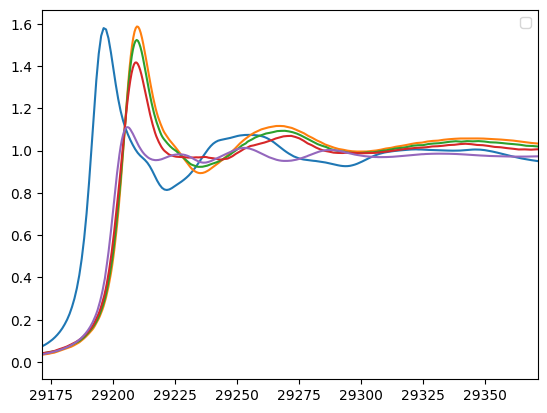

Press any key to continue

2


[root] INFO : Plot first derivate for first five groups
[root] INFO : Ploting Mu
[matplotlib.legend] WARNING : No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2
Plot first derivate for first five groups 

[<Group 0x2b48a4f9dc0>, <Group 0x2b48a37f970>, <Group 0x2b48a463ca0>, <Group 0x2b48a3f3a60>, <Group 0x2b48a37f460>, <Group 0x2b48a4e8310>, <Group 0x2b48a4429a0>] ['0', '1', '2', '3', '4'] ['1', '0', '1', '1', '0', '0', '0', '0', '0'] ['20', '60', '-15', '7']
['20', '60', '-15', '7']
0 <class 'str'>
1 <class 'str'>
2 <class 'str'>
3 <class 'str'>
4 <class 'str'>


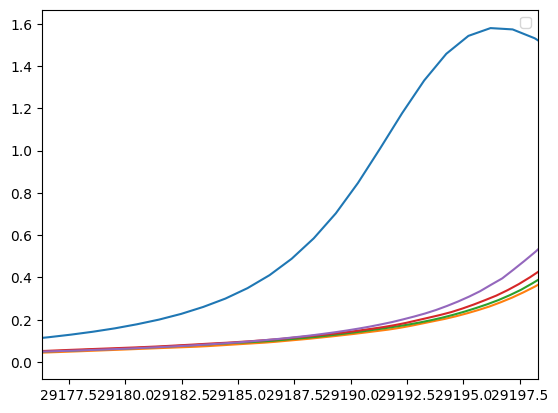

Press any key to continue

2


[root] INFO : Showing SnO2 and Sn foil LCF for H2
[root] INFO : Lineal combination fitting


2
Showing SnO2 and Sn foil LCF for H2 

Press any key to continue

2


[root] INFO : Showing SnO2 and Sn foil LCF for Ar
[root] INFO : Lineal combination fitting


2
Showing SnO2 and Sn foil LCF for Ar 

Press any key to continue

2


[root] INFO : Showing SnO2 and Sn foil LCF for air
[root] INFO : Lineal combination fitting


2
Showing SnO2 and Sn foil LCF for air 

Press any key to continue

2


[root] INFO : Showing SnO2 and Sn H2-H2 LCF for H2
[root] INFO : Lineal combination fitting


2
Showing SnO2 and Sn H2-H2 LCF for H2 

Press any key to continue

2


[root] INFO : Showing SnO2 and Sn H2-H2 LCF for Ar
[root] INFO : Lineal combination fitting


2
Showing SnO2 and Sn H2-H2 LCF for Ar 

Press any key to continue

2


[root] INFO : Showing SnO2 and Sn H2-H2 LCF for air
[root] INFO : Lineal combination fitting


2
Showing SnO2 and Sn H2-H2 LCF for air 

Press any key to continue

2
2


In [10]:
# create the path for storing results
base_path = Path("./" , base_prefix)
Path(base_path).mkdir(parents=True, exist_ok=True)

# create log file (store processing steps)
log_file = Path("./",base_path,"process.log")
print(log_file)
# set path for log
set_logger(log_file)

logging.info("Started processing")
logging.info("Input variables:")
logging.info("prefix = " + base_prefix)


# get the files list (from csv file), no ID, no headers
logging.info("reading from athena file = " + athena_groups_file)
files_list, _ = hcsv.get_csv_data(athena_groups_file, "", False)
files_list = list(files_list.values())

# get the operations list (from csv file), no ID, no headers
logging.info("reading from operations file = " + operations_list_file )
operations_list, _ = hcsv.get_csv_data(operations_list_file, "", False)
operations_list = list(operations_list.values())

# retrieve data
logging.info("recovering data groups")
athena_groups = get_data(files_list)
logging.info("recovered " + str(len(athena_groups)) + " data groups")

# perform operations

for wf_operation in operations_list:
    # operation id
    op_id = int(wf_operation[0])
    # groups used in the operation
    op_gr = wf_operation[1].split('|')
    # plotting parameters for the operation
    op_ep = wf_operation[2].split('|')
    # graph min-max
    op_mm = wf_operation[4].split('|')
    # result group name
    op_rgn = wf_operation[5].split('|')
    # y offsets for plotting
    op_yofp = wf_operation[6].split('|')
    # x offsets for plotting (do they exist?)
    op_xofp = wf_operation[7].split('|')
    # display text for the operation
    op_msg = wf_operation[3];
    print(op_msg, "\n")
    logging.info(op_msg)
    if (op_id == 1 or op_id == 2):
        # operations 1 and 2 are the same only the plotting parameters change
        logging.info("Ploting Mu")
        print(athena_groups, op_gr, op_ep, op_mm)
        plot_norm_mu_energy(athena_groups, op_gr, op_ep, op_mm)
    elif (op_id == 3):
        # operation 3 is the lineal combination fitting
        logging.info("Lineal combination fitting")
        #do_lcf(athena_groups, op_gr, op_ep, op_mm)
    elif (op_id == 4):
        # operation 4 is merge
        project_groups = do_merge(athena_groups, op_gr, op_rgn);
    elif (op_id == 5):
        # operation 5 is smoothing
        project_groups = do_smooth(athena_groups, op_gr, op_rgn);
    elif (op_id == 6):
        # operation 6 is plotting k.
        # reset plot after each operation
        print("plot in k")
    print("Press any key to continue\n")
    a = input()
    print(a)



In [11]:
athena_groups[0]

Attribute,Type
energy,ndarray
mu,ndarray
athena_params,Group
stddev,ndarray
label,str
epsr,float
epsk,float
sel,int
datatype,str
filename,str


In [12]:
files_list

[['..\\Larch\\wf_data\\pub_037\\XAFS_prj\\SnO2 0.9 2.6-13.5 gbkg.prj',
  'SnO2 0.9',
  'SnO2'],
 ['..\\Larch\\wf_data\\pub_037\\XAFS_prj\\Sn K-edge\\PtSn_OCO.prj',
  'PtSn_OCO rebinned',
  'air'],
 ['..\\Larch\\wf_data\\pub_037\\XAFS_prj\\Sn K-edge\\PtSn_OCA.prj',
  'PtSn_OCA rebinned',
  'Ar'],
 ['..\\Larch\\wf_data\\pub_037\\XAFS_prj\\Sn K-edge\\PtSn_OCH.prj',
  'PtSn_OCH rebinned',
  'H2'],
 ['..\\Larch\\wf_data\\pub_037\\XAFS_prj\\Sn foil.prj', 'merge', 'Sn Foil'],
 ['..\\Larch\\wf_data\\pub_037\\XAFS_prj\\Sn K-edge\\PtSn_OC.prj',
  'PtSn_OC_MERGE_CALIBRATE rebinned',
  'PtSn'],
 ['..\\Larch\\wf_data\\pub_037\\XAFS_prj\\Sn K-edge\\PtSn_OCH_H2.prj',
  'PtSn_OCH rebinned',
  'H2-H2']]

In [13]:
operations_list

[['1',
  '0|1|2|3|4',
  '1|0|1|0|0|0|0|0|0',
  'Show normalised E plot for first five groups',
  '20|60|-20|180',
  '',
  '0',
  '0'],
 ['2',
  '0|1|2|3|4',
  '1|0|1|1|0|0|0|0|0',
  'Plot first derivate for first five groups',
  '20|60|-15|7',
  '',
  '0',
  '0'],
 ['3',
  '3|0|4',
  '0|0|0|1|0|0|0|0|0',
  'Showing SnO2 and Sn foil LCF for H2',
  '20|60|-20|60',
  '',
  '0',
  '0'],
 ['3',
  '2|0|4',
  '0|0|0|1|0|0|0|0|0',
  'Showing SnO2 and Sn foil LCF for Ar',
  '20|60|-20|60',
  '',
  '0',
  '0'],
 ['3',
  '1|0|4',
  '0|0|0|1|0|0|0|0|0',
  'Showing SnO2 and Sn foil LCF for air',
  '20|60|-20|60',
  '',
  '0',
  '0'],
 ['3',
  '3|0|6',
  '0|0|0|1|0|0|0|0|0',
  'Showing SnO2 and Sn H2-H2 LCF for H2',
  '20|60|-20|60',
  '',
  '0',
  '0'],
 ['3',
  '2|0|6',
  '0|0|0|1|0|0|0|0|0',
  'Showing SnO2 and Sn H2-H2 LCF for Ar',
  '20|60|-20|60',
  '',
  '0',
  '0'],
 ['3',
  '1|0|6',
  '0|0|0|1|0|0|0|0|0',
  'Showing SnO2 and Sn H2-H2 LCF for air',
  '20|60|-20|60',
  '',
  '0',
  '0']]

In [19]:
files_list

[['..\\Larch\\wf_data\\pub_037\\XAFS_prj\\SnO2 0.9 2.6-13.5 gbkg.prj',
  'SnO2 0.9',
  'SnO2'],
 ['..\\Larch\\wf_data\\pub_037\\XAFS_prj\\Sn K-edge\\PtSn_OCO.prj',
  'PtSn_OCO rebinned',
  'air'],
 ['..\\Larch\\wf_data\\pub_037\\XAFS_prj\\Sn K-edge\\PtSn_OCA.prj',
  'PtSn_OCA rebinned',
  'Ar'],
 ['..\\Larch\\wf_data\\pub_037\\XAFS_prj\\Sn K-edge\\PtSn_OCH.prj',
  'PtSn_OCH rebinned',
  'H2'],
 ['..\\Larch\\wf_data\\pub_037\\XAFS_prj\\Sn foil.prj', 'merge', 'Sn Foil'],
 ['..\\Larch\\wf_data\\pub_037\\XAFS_prj\\Sn K-edge\\PtSn_OC.prj',
  'PtSn_OC_MERGE_CALIBRATE rebinned',
  'PtSn'],
 ['..\\Larch\\wf_data\\pub_037\\XAFS_prj\\Sn K-edge\\PtSn_OCH_H2.prj',
  'PtSn_OCH rebinned',
  'H2-H2']]